# Implementing the Machine Learning Model
 
### Authors

| Name | Roll Number |
| - | - |
| Gautam Singh | CS21BTECH11018 |
| Jaswanth Beere | BM21BTECH11007 |

This `.ipynb` file trains a Poisson regression model on the data, and compares its performance on some test data to a standard linear regression model trained on the same data.

## Package Imports

The packages required for this exercise are listed below.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Loading Datasets

The `pandas` library is used to load the `csv` datasets.

In [10]:
df = pd.read_csv("../data/Meal Durations.csv")

## Exploratory Data Analaysis

In this section, we perform an exploratory data analysis on the given dataset by plotting the time taken to complete meals of each type for a given day.

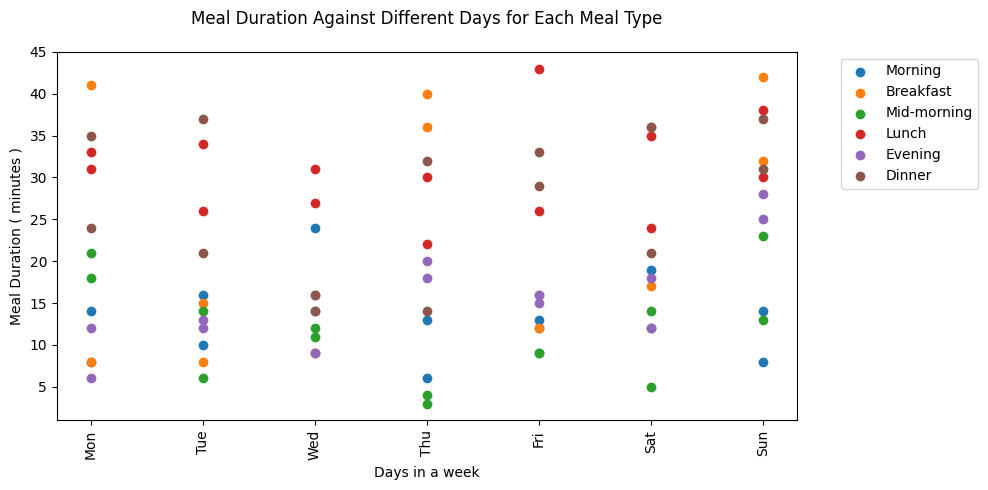

In [11]:
# Sort the dataframe for EDA
df = df.sort_values("day").reset_index(drop=True)

# Strings for plots and legend
meal_type_meanings = ["Morning", "Breakfast", "Mid-morning", "Lunch", "Evening", "Dinner"]
day_meanings = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
plt.figure(figsize=(10, 5))
for meal_type in range(6):
    # Filter data for the specific meal type
    filtered_data = [df['meal_duration'][i] for i in range(len(df['meal_type'])) if df['meal_type'][i] == meal_type]
    days = [day_meanings[df['day'][i]] for i in range(len(df['meal_type'])) if df['meal_type'][i] == meal_type]
  
    # Plotting
    plt.scatter(days, filtered_data, label=f"{meal_type_meanings[meal_type]}")

# Aesthetics
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Days in a week')
plt.ylabel('Meal Duration ( minutes )')
plt.xticks(rotation='vertical')
plt.title("Meal Duration Against Different Days for Each Meal Type", pad=20)
plt.tight_layout()
plt.show()

## Preprocessing

The `start_time` feature contains the time (in 24-hour format `HHMM`) when the subject started eating their meal. It must be normalized to make it a suitable feature for applying the Poisson regression model.

In [12]:
df['start_time'] = df['start_time'].apply(lambda x: (int(str(x)[0]) * 60 + int(str(x)[1:])) if x < 999 else (int(str(x)[:2]) * 60 + int(str(x)[2:])))
df['start_time'] = df['start_time']/(24*60)

Finally, the data is sampled using _random sampling_. 80 percent of this data is _training dataset_, and the remaining 20 percent becomes the _test dataset_.

In [13]:
# Randomly shuffle the data
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data: 80% for training and 20% for testing
split_index = int(0.8 * len(shuffled_df))
train_df = shuffled_df.iloc[:split_index]
test_df = shuffled_df.iloc[split_index:]

print(f"Total: {len(df)}, Train: {len(train_df)}, Test: {len(test_df)}")

Total: 84, Train: 67, Test: 17


## Training

### Poisson Regression

The Poisson regression model is set up and trained in the code cell below.

In [14]:
# Separate independent and dependent variables
X = train_df.drop(columns='meal_duration').to_numpy()
y = train_df['meal_duration'].to_numpy()
X = np.hstack([np.ones((X.shape[0], 1)), X])  # Add bias/intercept term

# Poisson regression via gradient ascent
def compute_lambda(X, beta):
    return np.exp(X @ beta)

def gradient_log_likelihood(X, y, beta):
    lambda_ = compute_lambda(X, beta)
    return X.T @ (y - lambda_)

def poisson_regression_GD(X, y, eta=1e-6, num_iter=1e5):
    beta = np.zeros(X.shape[1])
    for i in range(int(num_iter)):
        gradient = gradient_log_likelihood(X, y, beta)
        beta += eta * gradient  # gradient ascent since we maximize log-likelihood
    return beta

# Training the model
beta = poisson_regression_GD(X, y)

# Analyzing the importance of parameters
importance = abs(beta)
sorted_indices = np.argsort(importance)[::-1]
column_names = ['bias'] + train_df.drop(columns='meal_duration').columns.tolist()

# Display learned parameters
print("Learned parameters:")
for idx in sorted_indices:
    print(f"{column_names[idx]}: {importance[idx]}")

Learned parameters:
bias: 1.8878167290715318
num_courses: 0.5867384711516039
start_time: 0.3797462009379705
is_holiday: 0.15798596095713865
location: 0.14648007029461138
busy_after: 0.0610959570641643
meal_type: 0.0594479724200499
day: 0.03413970477413641
hunger: 0.022143495181595432


Based on the learned parameters, the more important parameters are those with a larger absolute weight, such as `num_courses`, `start_time`, `is_holiday` and `location`. Qualitatively, these do make sense as factors that can affect mealtime.

### Linear Regression

The `scikit-learn` has an out-of-the box implementation for linear regression, which is used on this dataset.

In [16]:
# Fit a linear regression model to the data
lr = LinearRegression()
lr.fit(X, y)


Linear Regression RMSE: 10.282256989733012


## Testing

The _root mean squared error_ (RMSE) is used as an evaluation metric.

### Poisson Regression

The code cell below evaluates the RMSE for the Poisson regression model.

In [15]:
# Test the learned Poisson regression model
X_test = test_df.drop(columns='meal_duration').to_numpy()
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])  # Add bias/intercept term
predictions = np.exp(X_test @ beta)

# Function to compute root mean squared error given true data
def root_mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)**0.5

# Extract actual values from test_df
y_test = test_df['meal_duration'].to_numpy()

# Compute RMSE
rmse = root_mean_squared_error(y_test, predictions)

print(f"Poisson Regression RMSE: {rmse}")

Poisson Regression RMSE: 12.721461498656806


### Linear Regression

The code cell below evaluates the RMSE for the linear regression model.

In [ ]:
# Find model predictions on test data
lr_predictions = lr.predict(X_test)

# Compute RMSE for linear regression
rmse_lr = root_mean_squared_error(y_test, lr_predictions)

print(f"Linear Regression RMSE: {rmse_lr}")

## Results

Though time-series data was used, it turns out that linear regression performs better than Poisson regression. This is because of the many optimizations `scikit-learn` have in their solvers for this model. Additionally, the dataset size is very small, which implies that it may not follow a Poisson distribution.